Model: ARIMA(0, 0, 0) - RMSE Train: 1.0381, RMSE Test: 0.6782
Model: ARIMA(0, 0, 1) - RMSE Train: 1.0300, RMSE Test: 0.6802
Model: ARIMA(0, 0, 2) - RMSE Train: 0.9473, RMSE Test: 0.6884
Model: ARIMA(1, 0, 0) - RMSE Train: 1.0236, RMSE Test: 0.6815
Model: ARIMA(1, 0, 1) - RMSE Train: 0.9995, RMSE Test: 0.6717
Model: ARIMA(1, 0, 2) - RMSE Train: 0.9402, RMSE Test: 0.6652
Model: ARIMA(2, 0, 0) - RMSE Train: 0.9465, RMSE Test: 0.6697
Model: ARIMA(2, 0, 1) - RMSE Train: 0.9424, RMSE Test: 0.6798
Model: ARIMA(2, 0, 2) - RMSE Train: 0.9401, RMSE Test: 0.6675
Model: ARIMA(0, 1, 0) - RMSE Train: 1.5773, RMSE Test: 1.7475
Model: ARIMA(0, 1, 1) - RMSE Train: 1.0552, RMSE Test: 0.6711
Model: ARIMA(0, 1, 2) - RMSE Train: 1.0214, RMSE Test: 0.8180
Model: ARIMA(1, 1, 0) - RMSE Train: 1.0564, RMSE Test: 1.3901
Model: ARIMA(1, 1, 1) - RMSE Train: 0.9903, RMSE Test: 0.8665
Model: ARIMA(1, 1, 2) - RMSE Train: 0.9844, RMSE Test: 0.7812
Model: ARIMA(2, 1, 0) - RMSE Train: 1.0115, RMSE Test: 1.1080
Model: A

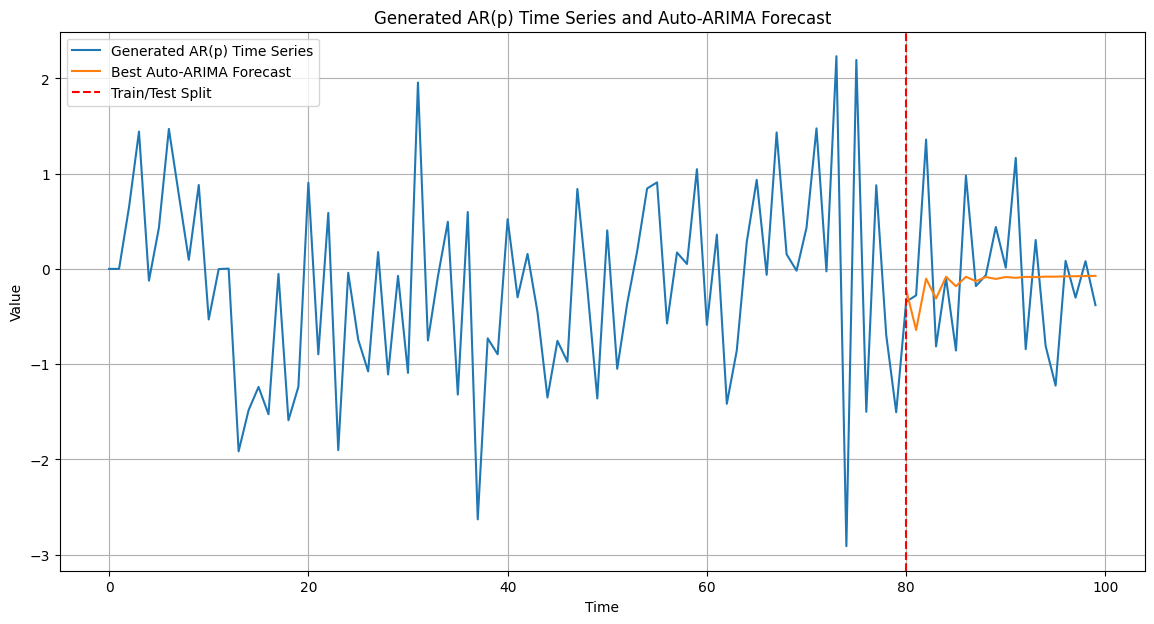

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima.arima import ARIMA
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Set seed for reproducibility
np.random.seed(42)

# Parameters for AR(p) model
n_samples = 100
p = 2  # Order of the AR model
coeffs = np.random.uniform(-0.5, 0.5, p)
noise_std = 1.0  # Standard deviation of the noise

# Generate AR(p) time series
ar_series = np.zeros(n_samples)
for t in range(p, n_samples):
    ar_series[t] = np.dot(coeffs, ar_series[t-p:t][::-1]) + np.random.normal(0, noise_std)

# Split data into train and test sets
train_size = int(len(ar_series) * 0.8)
train, test = ar_series[:train_size], ar_series[train_size:]

# Ranges of p, d, q
max_range = 3
p_range = range(0, max_range)
d_range = range(0, max_range-1)
q_range = range(0, max_range)

# Placeholder for results
results = []

# Loop over all combinations of p, d, q
for d in d_range:
    for p_val in p_range:
        for q in q_range:
            try:
                # Fit ARIMA model
                model = ARIMA(order=(p_val, d, q), seasonal=False, suppress_warnings=True)
                model_fit = model.fit(train)
                
                # Forecast the test set
                forecast = model_fit.predict(n_periods=len(test))
                
                # Calculate evaluation metrics for training and test sets
                train_forecast = model_fit.predict_in_sample()
                rmse_train = np.sqrt(mean_squared_error(train, train_forecast))
                rmse_test = np.sqrt(mean_squared_error(test, forecast))
                
                results.append({
                    'order': (p_val, d, q),
                    'rmse_train': rmse_train,
                    'rmse_test': rmse_test
                })
                
                print(f"Model: ARIMA{(p_val, d, q)} - RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}")
            
            except Exception as e:
                # Handle models that fail to fit
                print(f"Model: ARIMA{(p_val, d, q)} - Failed to fit. Error: {e}")

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print("\nRMSE for all models:")
print(results_df)

# Find the best model based on RMSE for the test set
best_model_info = results_df.loc[results_df['rmse_test'].idxmin()]
best_model_order = best_model_info['order']
estimated_p, estimated_d, estimated_q = best_model_order

# Fit the best model again for summary and plotting
best_model = ARIMA(order=best_model_order, seasonal=False, suppress_warnings=True)
best_model_fit = best_model.fit(train)

# Print the best model summary
print(f"\nBest model based on RMSE Test: ARIMA{best_model_order}")
print(best_model_fit.summary())

# Print a message telling if the estimated ARIMA(p,d,q) model is the same as the AR(p) generated
if estimated_p == p and estimated_d == 0 and estimated_q == 0:
    print(f"The estimated ARIMA({estimated_p},{estimated_d},{estimated_q}) model is the same as the AR({p}) model that generated the series.")
else:
    print(f"The estimated ARIMA({estimated_p},{estimated_d},{estimated_q}) model is NOT the same as the AR({p}) model that generated the series.")

# Forecast the test set using the best model
best_forecast = best_model_fit.predict(n_periods=len(test))

# Plot the generated AR(p) time series and forecasts
plt.figure(figsize=(14, 7))
plt.plot(ar_series, label='Generated AR(p) Time Series')
plt.plot(np.arange(train_size, train_size + len(test)), best_forecast, label='Best Auto-ARIMA Forecast')
plt.axvline(x=train_size, color='r', linestyle='--', label='Train/Test Split')
plt.title('Generated AR(p) Time Series and Auto-ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
